In [1]:
import time
import json
import itertools
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Manipulations
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

# Tuning & Splitting Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Loading Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation Liabraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set_style('darkgrid')
sns.color_palette('pastel')

directory = r'/kaggle/input/fraud-detection/transactions.txt'

with open(directory) as txt_file:
    lines = txt_file.readlines()

trxn_data = []
for line in lines:
    trxn_data.append(json.loads(line))

trxn = pd.DataFrame(trxn_data)
trxn = trxn.replace(r'', np.NaN)

In [2]:
trxn.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [3]:
fraud_trxn = trxn[trxn['isFraud'] == True]

print("Total number of transactions in the dataframe: {}".format(trxn.shape[0]))
print("Total number of fields in a single records: {}".format(trxn.shape[1]))

print("Number of rows having fraud transactions: {}".format(fraud_trxn.shape[0]))
print("Number of legit transactions: {}".format(trxn.shape[0] - fraud_trxn.shape[0]))
print("Number of rows in fraud transactions affected by missing values: {}".format(fraud_trxn.shape[0] - fraud_trxn.dropna().shape[0]))

Total number of transactions in the dataframe: 786363
Total number of fields in a single records: 29
Number of rows having fraud transactions: 12417
Number of legit transactions: 773946
Number of rows in fraud transactions affected by missing values: 12417


In [4]:
print("Unique number of customers: {}".format(len(trxn['customerId'].unique())))
print("Unique number of Merchants: {}".format(len(trxn['merchantName'].unique())))
print("Unique Account Numbers: {}".format(len(trxn['accountNumber'].unique())))

Unique number of customers: 5000
Unique number of Merchants: 2490
Unique Account Numbers: 5000


In [5]:
trxn.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [6]:
trxn.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis=1, inplace=True)

In [7]:
trxn.isnull().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

In [8]:
trxn.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


# Data Visualization

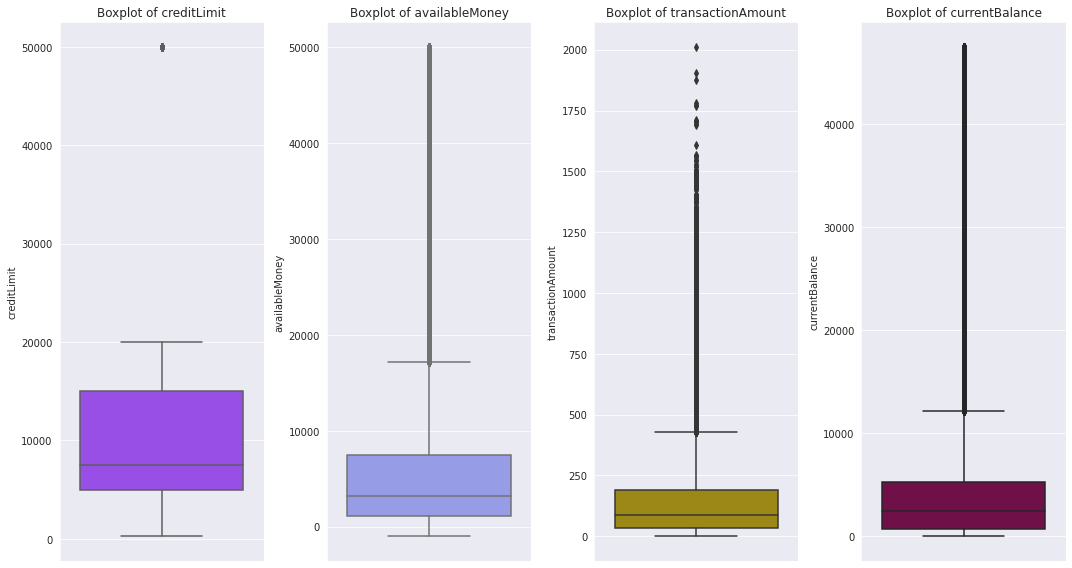

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

fields = ["creditLimit", "availableMoney", "transactionAmount", "currentBalance"]
palette = ["#9736FF", "#8992F3", "#B29800", "#80004C"]
for ax, field, color in itertools.zip_longest(axs.ravel(), fields, palette): 
    sns.boxplot(data=trxn, y=trxn[field], ax=ax, color=color)
    ax.set_title('Boxplot of ' + str(field))
    plt.tight_layout()


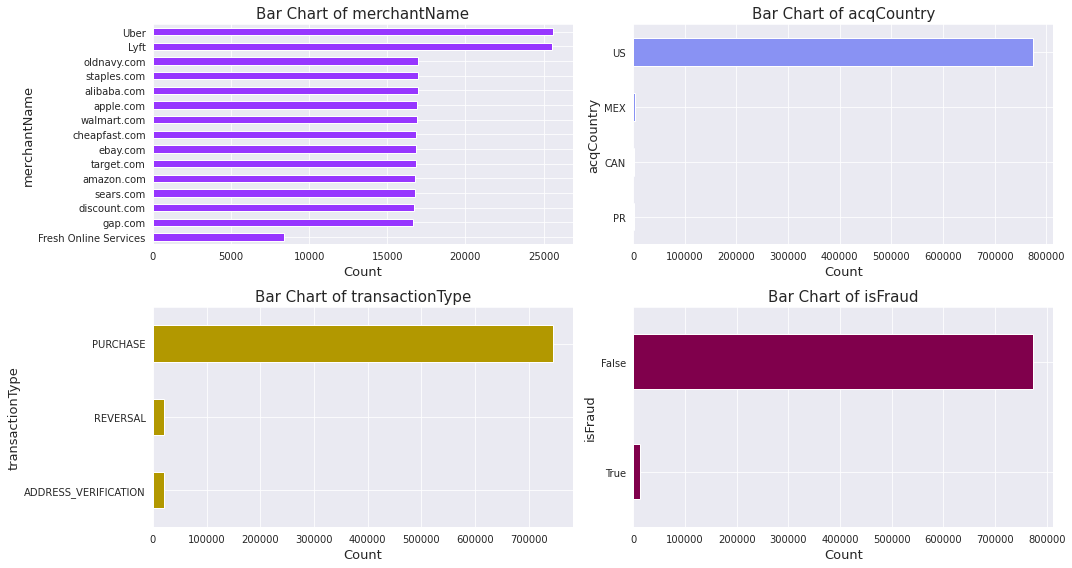

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

fields = ['merchantName', 'acqCountry', 'transactionType', 'isFraud']
palette = ["#9736FF", "#8992F3", "#B29800", "#80004C"]
for ax, field, color in itertools.zip_longest(axs.ravel(), fields, palette):  
    trxn[field].value_counts().head(15).sort_values().plot(kind = 'barh', ax = ax, color=color)
    ax.set_title('Bar Chart of ' + str(field), fontsize=15)
    ax.set_xlabel('Count', fontsize=13)
    ax.set_ylabel(str(field), fontsize=13)
    plt.tight_layout()

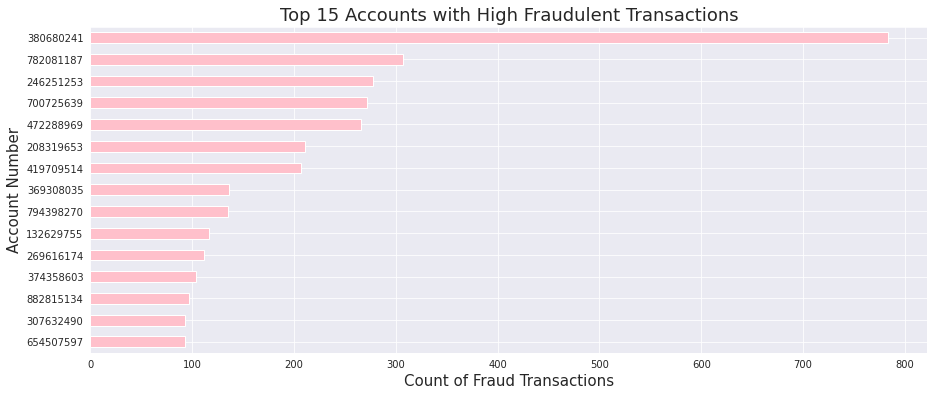

In [11]:
plt.figure(figsize=(15,6))
fraud_accounts_count = fraud_trxn['accountNumber'].value_counts()
fraud_accounts_count.head(15).sort_values().plot(kind = 'barh', color='pink')
plt.xlabel('Count of Fraud Transactions', fontsize=15)
plt.ylabel('Account Number', fontsize=15)
plt.title('Top 15 Accounts with High Fraudulent Transactions', fontsize=18)
plt.show()

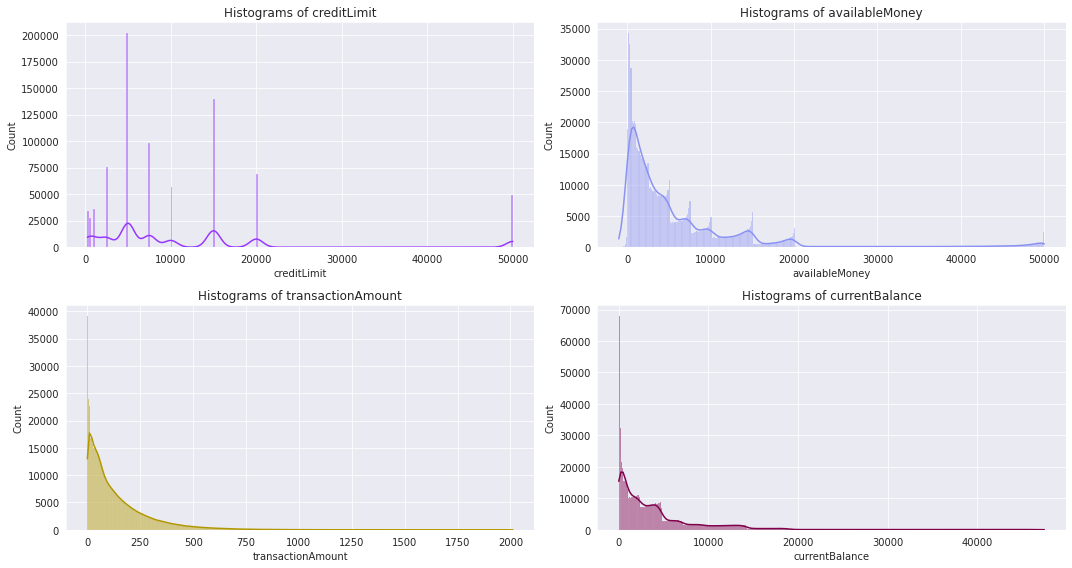

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

fields = ["creditLimit", "availableMoney", "transactionAmount", "currentBalance"]
palette = ["#9736FF", "#8992F3", "#B29800", "#80004C"]
for ax, field, color in itertools.zip_longest(axs.ravel(), fields, palette): 
    sns.histplot(data = trxn, x=trxn[field], ax=ax, color=color, kde=True)
    ax.set_title('Histograms of ' + str(field))
    plt.tight_layout()

# Histogram of Transaction Amount

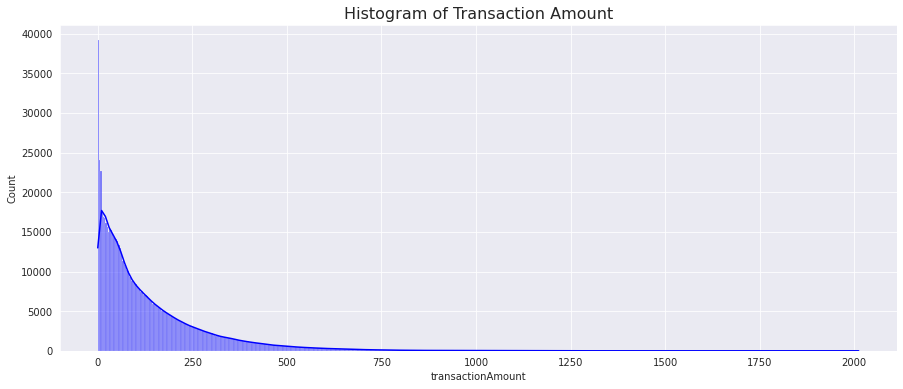

In [13]:
plt.figure(figsize=(15,6))
sns.histplot(data=trxn, x="transactionAmount", kde=True, color = 'blue', bins="auto")
plt.title('Histogram of Transaction Amount', fontsize=16)
plt.show();

### The transaction amount is highly right skewed which is kind of expected because large transactions are expected to be infrequent. Low transaction amount transactions are highly frequent which is also expected. 

In [14]:
#sns.pairplot(scaled_features, hue="isFraud");

<AxesSubplot:>

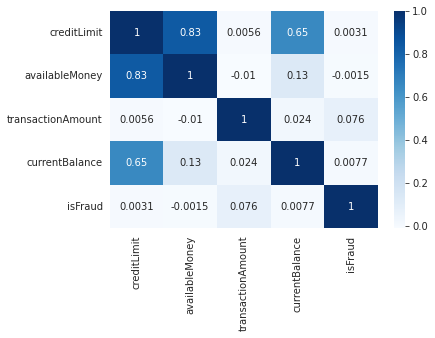

In [15]:
corr = trxn[["creditLimit", "availableMoney", "transactionAmount", "currentBalance", 'isFraud']].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

# Data Wrangling

# Finding Reversed and Multi-swipe transactions

In [16]:
trxn[trxn["transactionType"] == "REVERSAL"].head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
39,574788567,574788567,2500.0,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,09,...,2015-10-13,2015-10-13,206,206,8522,REVERSAL,299.02,True,False,False
73,574788567,574788567,2500.0,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,05,...,2015-10-13,2015-10-13,579,579,4219,REVERSAL,67.28,True,False,False
101,924729945,924729945,50000.0,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,...,2014-07-25,2014-07-25,205,265,9459,REVERSAL,168.57,False,False,False
133,984504651,984504651,50000.0,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,05,...,2015-07-27,2015-07-27,640,640,8332,REVERSAL,3632.59,False,False,False
156,984504651,984504651,50000.0,41909.30,2016-01-25T20:39:15,81.73,AMC #724446,US,US,09,...,2015-07-27,2015-07-27,640,640,8332,REVERSAL,8090.70,True,False,False


# Feature Engineering and Data Processing for Model Building

In [17]:
scaler = MinMaxScaler()
numeric_feature_names = ["creditLimit", "availableMoney", "transactionAmount", "currentBalance"]
trxn[numeric_feature_names] = scaler.fit_transform(trxn[numeric_feature_names])
# Creating a new feature
trxn['cvv_matched_status'] = [False if actual_cvv != entered_cvv else True for actual_cvv, entered_cvv in zip(trxn['cardCVV'], trxn['enteredCVV'])]

In [18]:
# Drop Irrelevant Columns
df = trxn.drop(['accountNumber', 'cardCVV', 'enteredCVV', 'accountOpenDate',
                'currentExpDate', 'dateOfLastAddressChange', 'cardLast4Digits',
                'merchantName', 'transactionDateTime'], axis=1)

In [19]:
df.head()

,customerId,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvv_matched_status
0,737265056,0.095477,0.117744,0.048992,US,US,02,01,rideshare,PURCHASE,0.0,False,False,False,True
1,737265056,0.095477,0.117744,0.037041,US,US,09,01,entertainment,PURCHASE,0.0,True,False,False,True
2,737265056,0.095477,0.117744,0.003714,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,True
3,737265056,0.095477,0.117744,0.003714,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,True
4,830329091,0.095477,0.117744,0.035386,US,US,02,01,fastfood,PURCHASE,0.0,True,False,False,True


# Candidate Features For Model Building

In [48]:
# Candidate Columns for Model Building
df.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionAmount',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud',
       'cvv_matched_status'],
      dtype='object')

In [21]:
target = df['isFraud']
features = df.drop('isFraud', axis=1)

# Performing Under Sampling to balance the dataset and minimize the computation time
sampled_features, sampled_target = RandomUnderSampler(sampling_strategy='majority',
                                                      random_state=3).fit_resample(features, target)
# Number of records before and after sampling
print('Recorded transactions before sampling: {}'.format(df.shape))
print('Records After Sampling: {}'.format(sampled_features.shape))

Recorded transactions before sampling: (786363, 15)
Records After Sampling: (24834, 14)


In [22]:
sampled_features['isFraud'] = sampled_target
sampled_customer_ids = sampled_features['customerId']
sampled_features.drop('customerId', axis=1, inplace=True)

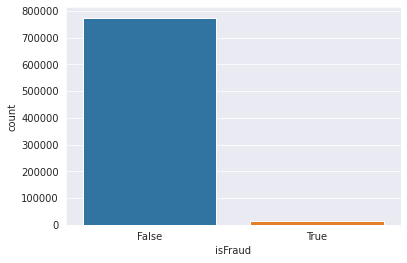

In [23]:
sns.countplot(data=df, x='isFraud');

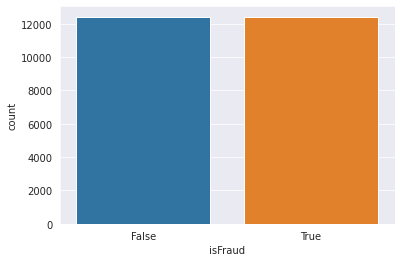

In [24]:
sns.countplot(data=sampled_features, x='isFraud');

In [25]:
sampled_features.head()

,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,cvv_matched_status,isFraud
0,0.045226,0.028246,0.050772,US,US,05,01,rideshare,PURCHASE,0.043473,False,False,True,False
1,0.095477,0.066649,0.018260,US,US,09,01,fastfood,PURCHASE,0.054868,True,False,True,False
2,0.015075,0.021971,0.010206,US,US,05,01,online_retail,PURCHASE,0.018632,False,False,True,False
3,0.000000,0.024372,0.078716,US,US,05,01,online_gifts,PURCHASE,0.000263,False,False,True,False
4,0.296482,0.097387,0.095156,US,US,09,01,online_gifts,PURCHASE,0.232392,False,False,True,False


In [26]:
# Imputation with most frequent values
sampled_features = sampled_features.fillna(sampled_features.mode().iloc[0])

In [27]:
sampled_features.head()

,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,cvv_matched_status,isFraud
0,0.045226,0.028246,0.050772,US,US,05,01,rideshare,PURCHASE,0.043473,False,False,True,False
1,0.095477,0.066649,0.018260,US,US,09,01,fastfood,PURCHASE,0.054868,True,False,True,False
2,0.015075,0.021971,0.010206,US,US,05,01,online_retail,PURCHASE,0.018632,False,False,True,False
3,0.000000,0.024372,0.078716,US,US,05,01,online_gifts,PURCHASE,0.000263,False,False,True,False
4,0.296482,0.097387,0.095156,US,US,09,01,online_gifts,PURCHASE,0.232392,False,False,True,False


In [28]:
cat_cols = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType']

In [29]:
label_encoder = preprocessing.LabelEncoder()
  
for cat in cat_cols:
    sampled_features[cat]= label_encoder.fit_transform(sampled_features[cat])


In [30]:
sampled_features['customer_id'] = sampled_customer_ids
sampled_features.set_index('customer_id', inplace=True)

# Modeling Fraud Transactions

In [31]:
y = sampled_features['isFraud']
X = sampled_features.drop(['isFraud'], axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (19867, 13)
X_test shape :  (4967, 13)
y_train shape :  (19867,)
y_test shape :  (4967,)


In [33]:
classifiers = {
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

In [41]:
start_time = time.time()

classifiers = []

# ----KNN Classifier (Lazy Learner)---------------------------------------------------------------------------

knears_params = {"n_neighbors": list(range(2,20,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, cv = 3, scoring = 'recall')
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_
classifiers.append(knears_neighbors)

# ----Decision Tree Classifier (Tree Based)-------------------------------------------------------------------

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,25,1)), 
              "min_samples_leaf": list(range(1,20,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv = 3, scoring = 'recall')
grid_tree.fit(X_train, y_train)

tree_clf = grid_tree.best_estimator_
classifiers.append(tree_clf)

# ----Ensemble Method (Bagging Tree Based)--------------------------------------------------------------------

rf_params = {
 'max_depth': [13],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [28, 30],
 'min_samples_leaf': [4],
 'n_estimators': [40]
}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv = 5, scoring = 'recall')
grid_rf.fit(X_train, y_train)

rf_clf = grid_rf.best_estimator_
classifiers.append(rf_clf)

# ----Ensemble Method (Boosting Tree Based)------------------------------------------------------------------

xgb_params = {
    'max_depth':[5],
    'n_estimators': [135, 140],
    'min_child_weight': [1],
    'gamma': [0.1],
    'learning_rate': [0.15, 0.2],
    'reg_alpha': [0.5],
    'reg_lambda': [0.6],
    'n_jobs': [-1]
}

grid_xgb = GridSearchCV(XGBClassifier(), xgb_params, cv = 5, scoring = 'recall')
grid_xgb.fit(X_train, y_train)

xgb_clf = grid_xgb.best_estimator_
classifiers.append(xgb_clf)

print("---Hyper-parameter Tuning Time is %s seconds ---" % (time.time() - start_time))

---Hyper-parameter Tuning Time is 428.6146790981293 seconds ---


In [42]:
for classifier in classifiers:
    model_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(str(classifier.__class__.__name__) +' Cross Validation Score: ', round(model_score.mean() * 100, 2).astype(str) + '%')

KNeighborsClassifier Cross Validation Score:  68.01%
DecisionTreeClassifier Cross Validation Score:  67.79%
RandomForestClassifier Cross Validation Score:  69.99%
XGBClassifier Cross Validation Score:  70.05%


# Model Evaluation

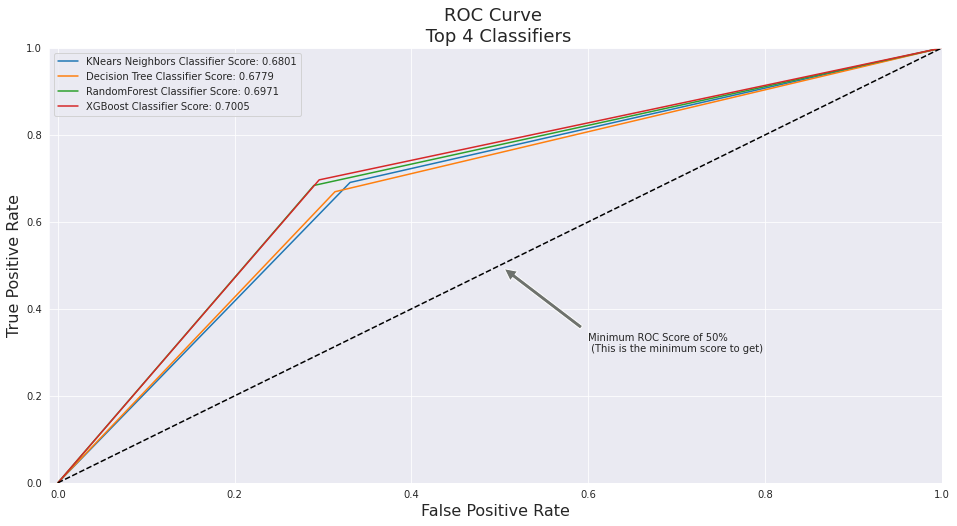

In [43]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)
rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5)
xgb_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=5)


knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rf_pred)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_train, xgb_pred)

def graph_roc_curve_multiple(knear_fpr, knear_tpr, tree_fpr, tree_tpr, rf_fpr, rf_tpr, xgb_fpr, xgb_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(rf_fpr, rf_tpr, label='RandomForest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train, xgb_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),)
    plt.legend()
    
graph_roc_curve_multiple(knear_fpr, knear_tpr, tree_fpr, tree_tpr, rf_fpr, rf_tpr, xgb_fpr, xgb_tpr)
plt.show()

In [44]:
for classifier in classifiers:
    pred = classifier.predict(X_test)
    print(str(classifier) + ' Acc Score: ',accuracy_score(y_test, pred))
    print(str(classifier) + ' Roc Auc Score: ',roc_auc_score(y_test, pred))
    print(str(classifier) + ' Precision Score: ',precision_score(y_test, pred))
    print(str(classifier) + ' Recall Score: ',recall_score(y_test, pred))
    print(str(classifier) + ' f1 score: ',f1_score(y_test, pred))
    print("======================================================")

KNeighborsClassifier(n_neighbors=17) Acc Score:  0.6843164888262533
KNeighborsClassifier(n_neighbors=17) Roc Auc Score:  0.6844583638638294
KNeighborsClassifier(n_neighbors=17) Precision Score:  0.6739736946990833
KNeighborsClassifier(n_neighbors=17) Recall Score:  0.6927488734125359
KNeighborsClassifier(n_neighbors=17) f1 score:  0.6832323232323232
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=7) Acc Score:  0.6893497080732837
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=7) Roc Auc Score:  0.6891105140703014
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=7) Precision Score:  0.6872393661384487
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=7) Recall Score:  0.6751331421548545
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=7) f1 score:  0.6811324653854103
RandomForestClassifier(max_depth=13, min_samples_leaf=4, min_samples_split=28,
                 

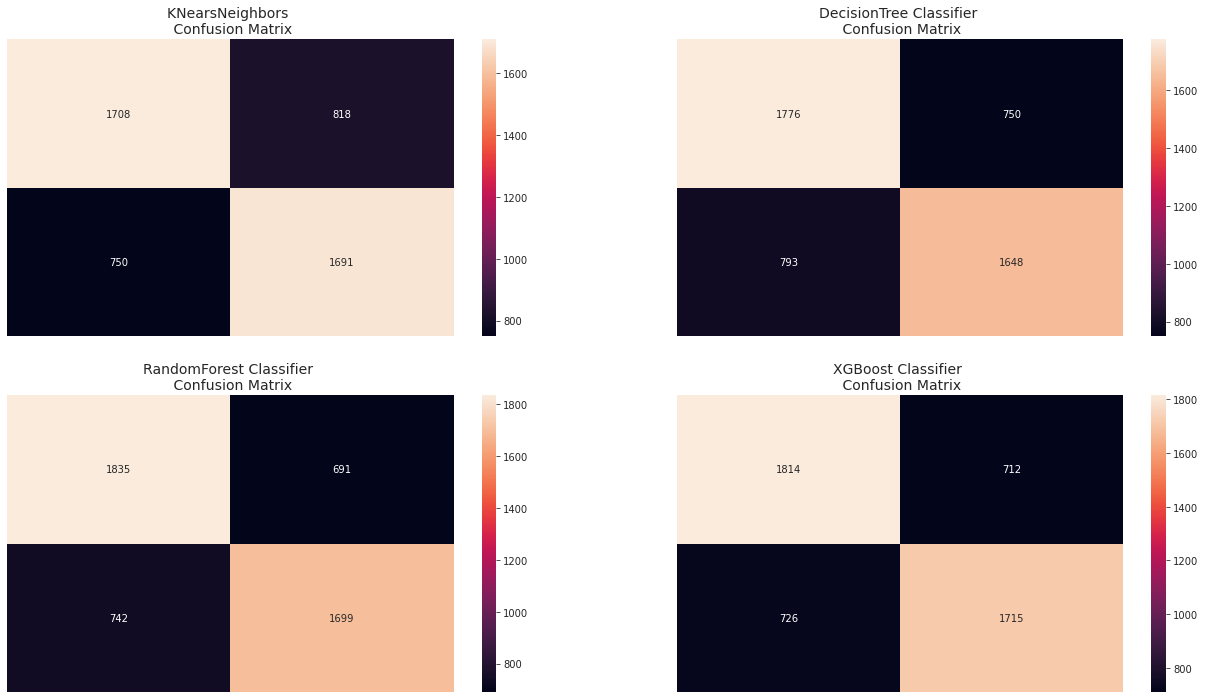

In [45]:
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
tree_cf = confusion_matrix(y_test, y_pred_tree)
rf_cf = confusion_matrix(y_test, y_pred_rf)
xgb_cf = confusion_matrix(y_test, y_pred_xgb)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(kneighbors_cf, ax=ax[0][0], annot=True, cmap='rocket', fmt='g')
ax[0, 0].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[0][1], annot=True, cmap='rocket', fmt='g')
ax[0][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(rf_cf, ax=ax[1][0], annot=True, cmap='rocket', fmt='g')
ax[1][0].set_title("RandomForest Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(xgb_cf, ax=ax[1][1], annot=True, cmap='rocket', fmt='g')
ax[1][1].set_title("XGBoost Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

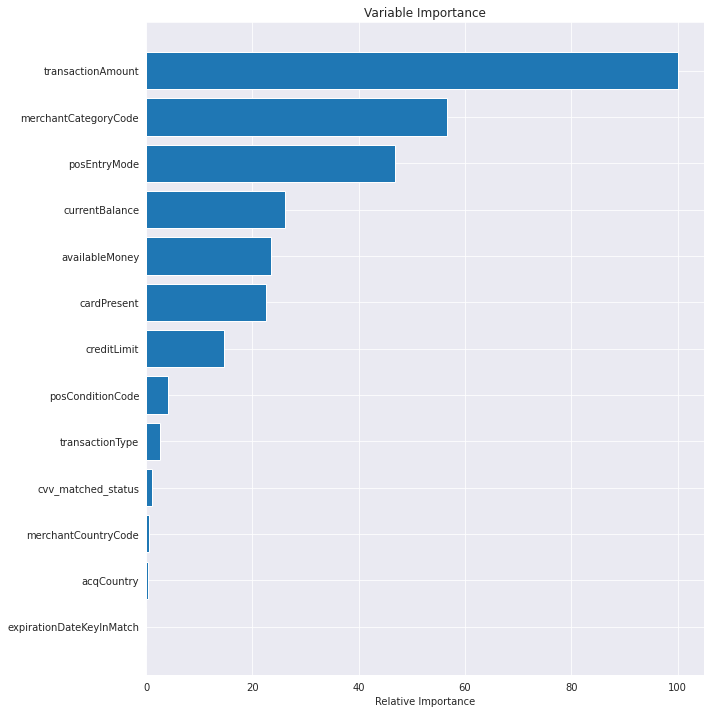

In [46]:
# Plotting the Relative Importance as per Random Forest model
feature_importance = rf_clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

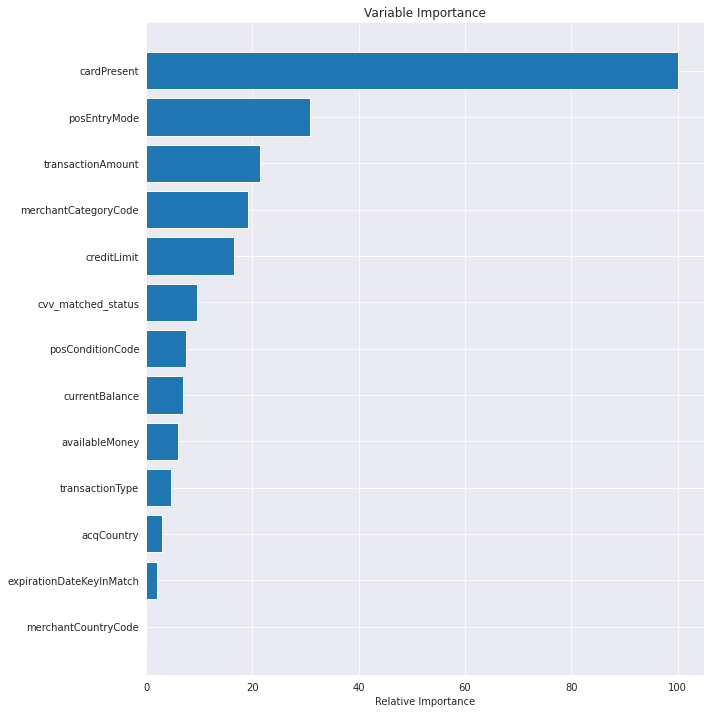

In [47]:
# Plotting the Relative Importance as per XGBoost model
feature_importance = xgb_clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Future Work

* Try different sampling techniques like SMOTE and see if performance increases. 
* Impute values by predicting the values of missing variable.
* Trying Linear Models like Logistic Regression for modeling the fraud cases (simple and easy to interpret).
